<a href="https://colab.research.google.com/github/HumanomeLab/TMDU_lecture_2019/blob/master/notebook/03_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備

## 0.1 GPUの有効化

以下の手順でGPUを選択する。
* 英語：Edit > Notebook Settings > Hardware Accelerator 
* 日本語：編集 > ノートブックの設定 > ハードウェアアクセレレータ

今回は、ほとんど効果が無いですが・・・

## 0.2 データのダウンロード

今まで、一度データをダウンロードした後、アップロードしてファイル名を変えていたが、トラブルが多かったので、今回は直接ダウンロードを行う。


In [49]:
!curl -O https://raw.githubusercontent.com/HumanomeLab/TMDU_lecture_2019/master/data/exp_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.9M  100 15.9M    0     0  25.2M      0 --:--:-- --:--:-- --:--:-- 25.2M


## 0.3 train.py のダウンロード

学習時に利用する関数が入っている、train.pyをダウンロードする

In [51]:
!curl -O https://raw.githubusercontent.com/HumanomeLab/TMDU_lecture_2019/master/src/train.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10496  100 10496    0     0  56128      0 --:--:-- --:--:-- --:--:-- 56128


以上を実行すると、左のタブのFiles に、exp_data.csv と train.py が現れているはずです。

# 1. NNを用いたクラス分類

PyTorchで深層学習を実施する。



## 1.1 訓練用の関数の読み込み

以下の1行で、train.py を読み込みます。

In [0]:
import train

In [67]:
import importlib
importlib.reload(train)

<module 'train' from '/content/train.py'>

## 1.2 深層学習の実施

関連のライブラリを読み込む

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

### 1.2.1 ネットワークの定義

入力層のノード数が906 (全遺伝子分)、中間層のノード数が64のネットワークを作成する。

In [0]:
# ネットワークモデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(906, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ネットワークをGPUに送る
device = train.device_name()
model = Net()
model = model.to(device)  

### 1.1.3 作成したネットワークの確認

自身が作成したネットワークが意図しているものと同じかどうかを確かめるため、表示する。PyTorchでは、torchsummary を用いるとモデルの概要を出力できる。

In [56]:
from torchsummary import summary
summary(model, (1,906))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          58,048
            Linear-2                 [-1, 1, 2]             130
Total params: 58,178
Trainable params: 58,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [57]:
# パラメータの設定
params = {
    "epochs":10,
    "batch_size":16,
    "lr":0.0001,
    "momentum":0.9,
}
# データの分割と学習の実施
model = Net()
model = model.to(device)  
summary(model, (1,906))
final_model, train_loss, val_loss = train.train_and_test("exp_data.csv", model, params)

# 学習したモデルの保存
model_file_name = "best_model.torch"
torch.save(final_model.state_dict(), model_file_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          58,048
            Linear-2                 [-1, 1, 2]             130
Total params: 58,178
Trainable params: 58,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.23
----------------------------------------------------------------
Settings:
	Device: cuda
	Batch size: 16
	Epochs: 10
	Learning rate: 0.0001
	Momentum(SGD): 0.9
	Step size for LR: 5
	Gamma for LR: 0.1

# of samples:
	Training: 596
	Validation: 199
	Test: 199

Epoch:0/9	train Loss: 0.7087 Acc: 0.4983 Time: 0.0787	val Loss: 0.7042 Acc: 0.4724 Time: 0.0126
Epoch:1/9	train Loss: 0.6643 Acc: 0.6376 Time: 0.0618	val Loss: 0.6352 Acc: 0.7286 Time: 0.0096
Epoch:2/9	train Loss: 0.6211 Acc: 0.7416 T

### 学習率の描画

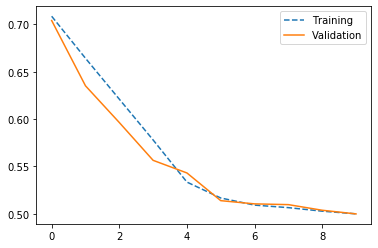

In [58]:
p1 = plt.plot(list(range(len(train_loss))), train_loss, linestyle="dashed")
p2 = plt.plot(list(range(len(val_loss))), val_loss, linestyle="solid")
plt.legend((p1[0], p2[0]), ("Training", "Validation"), loc=1)

## 1.3 モデルの変更 (Dropoutを追加する)

過学習傾向にある可能性があるので、過学習を避けるために、Dropoutを実施する。中間層でDropoutを実施する。
Dropout とは、ランダムにネットワークを間引いて学習することで、過学習を避ける際に利用される方法の一つ。

In [0]:
# ネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(906, 64)
        self.fc2 = nn.Linear(64, 2)
        self.drop = nn.Dropout(p=0.5)  # 確率0.5でdropoutすることを宣言

    def forward(self, x):
        x = F.relu(self.drop(self.fc1(x)))  # Dropoutの実施
        x = self.fc2(x)
        return x

# ネットワークをGPUに送る
model = Net()
model = model.to(device)  

In [60]:
summary(model, (1,906))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          58,048
           Dropout-2                [-1, 1, 64]               0
            Linear-3                 [-1, 1, 2]             130
Total params: 58,178
Trainable params: 58,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


再度、学習の実施。

In [61]:
# パラメータの設定
params = {
    "epochs":10,
    "batch_size":16,
    "lr":0.0001,
    "momentum":0.9,
}
# データの分割と学習の実施
model = Net()
model = model.to(device)  
summary(model, (1,906))
final_model, train_loss, val_loss = train.train_and_test("exp_data.csv", model, params)

# 学習したモデルの保存
model_file_name = "best_model.torch"
torch.save(final_model.state_dict(), model_file_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          58,048
           Dropout-2                [-1, 1, 64]               0
            Linear-3                 [-1, 1, 2]             130
Total params: 58,178
Trainable params: 58,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.23
----------------------------------------------------------------
Settings:
	Device: cuda
	Batch size: 16
	Epochs: 10
	Learning rate: 0.0001
	Momentum(SGD): 0.9
	Step size for LR: 5
	Gamma for LR: 0.1

# of samples:
	Training: 596
	Validation: 199
	Test: 199

Epoch:0/9	train Loss: 0.7077 Acc: 0.5688 Time: 0.0658	val Loss: 0.6489 Acc: 0.5879 Time: 0.0104
Epoch:1/9	train Loss: 0.6366 Acc: 0.6510 Time: 0.0603	val Loss: 0.6328 Acc

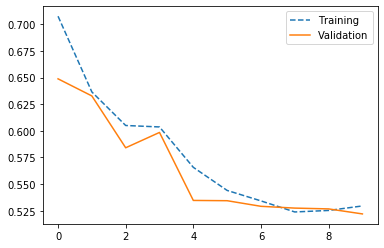

In [62]:
p1 = plt.plot(list(range(len(train_loss))), train_loss, linestyle="dashed")
p2 = plt.plot(list(range(len(val_loss))), val_loss, linestyle="solid")
plt.legend((p1[0], p2[0]), ("Training", "Validation"), loc=1)

層の数を増やしてみる。

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(906, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.drop(self.fc1(x)))
        x = F.relu(self.drop(self.fc2(x)))
        x = F.relu(self.drop(self.fc3(x)))
        x = self.fc4(x)
        return x

model = Net()
model = model.to(device)

In [64]:
summary(model, (1,906))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          29,024
           Dropout-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
           Dropout-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 8]             136
           Dropout-6                 [-1, 1, 8]               0
            Linear-7                 [-1, 1, 2]              18
Total params: 29,706
Trainable params: 29,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [65]:
# パラメータの設定
params = {
    "epochs":10,
    "batch_size":16,
    "lr":0.0001,
    "momentum":0.9,
}

# データの分割と学習の実施
model = Net()
model = model.to(device)  
summary(model, (1,906))
final_model, train_loss, val_loss = train.train_and_test("exp_data.csv", model, params)

# 学習したモデルの保存
model_file_name = "best_model.torch"
torch.save(final_model.state_dict(), model_file_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          29,024
           Dropout-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
           Dropout-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 8]             136
           Dropout-6                 [-1, 1, 8]               0
            Linear-7                 [-1, 1, 2]              18
Total params: 29,706
Trainable params: 29,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.12
----------------------------------------------------------------
Settings:
	Device: cuda
	Batch size: 16
	Epochs: 10
	Learning rate: 0.0001
	Momentum(SGD): 0.9
	Step size fo

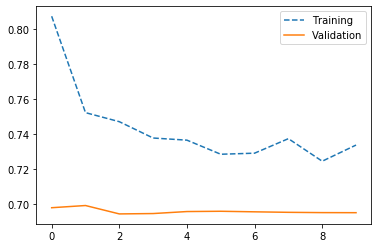

In [66]:
p1 = plt.plot(list(range(len(train_loss))), train_loss, linestyle="dashed")
p2 = plt.plot(list(range(len(val_loss))), val_loss, linestyle="solid")
plt.legend((p1[0], p2[0]), ("Training", "Validation"), loc=1)

以上で、発現量を利用したニューラルネットワークを実施した。層の数や層内のノードの数など、様々な変更可能な点が存在しているので、色々と試してみてほしい。